# Function Definitions

### Import libs and define functions

In [1]:
import numpy as np
from  matplotlib import pyplot as plt
import plotly.express as px
import pandas as pd
from data_loaders import load_dataset, load_inference_data, promptTechList, modelList, load_data_all, problem_list
import sys
import matplotlib
a=sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist])

sys.path.append('../')

### Assistant Functions

In [2]:
def group_list(data : list[tuple]) -> list[tuple] :
    dict = {}
    for item in data:
        if item[0] in dict:
            dict[item[0]].append(item[1])
        else:
            dict[item[0]] = [item[1]]
    
    return [(key, value) for key,value in dict.items()]

def first(lis):
    return lis[0]

def last(lis):
    return lis[-1]

### Analysis Function

In [3]:
def analysis_problem(problem : str) -> dict[str, dict[str, list]]:
    # formate the problem and its name
    problem_name = problem
    match problem:
        case 'Direct Boolean Computation'|'DirectBooleanComputation':
            from DirectBooleanComputation import response_evaluator
            problem = 'DirectBooleanComputation'
            problem_name = 'Direct Boolean Computation'

        case 'Indirect Boolean Computation'|'IndirectBooleanComputation':
            from IndirectBooleanComputation import response_evaluator
            problem = 'IndirectBooleanComputation'
            problem_name = 'Indirect Boolean Computation'
        
        case 'SAT':
            from SAT import response_evaluator
        
        case 'SAT Count'|'SATCount':
            from SATCount import response_evaluator
            problem = 'SATCount'
            problem_name = 'SAT Count'
        
        case 'TautologyQ':
            from TautologyQ import response_evaluator
        
        case 'EquivalentQ':
            from EquivalentQ import response_evaluator
        
        case 'CNF':
            from CNF import response_evaluator
        
        case 'DNF':
            from DNF import response_evaluator

    # load corresponding dataset
    dataset, inference_data = load_data_all(problem)
    
    # evaluate all the reponses
    evaluation_result = {
        model: {
            p: [
                (
                    dataObject['Complexity']
                        if type(dataObject['Complexity']) != list
                        else max(dataObject['Complexity']) - min(dataObject['Complexity'])
                    ,
                    response_evaluator(response['response'], dataObject)
                )
                    for dataObject, response in zip(dataset, inference_data[model][p])
                ]
            for p in promptTechList}
        for model in modelList
    }

    return evaluation_result

### Lazy Plot Function

In [5]:
def visualize_discrete_distribution(
        problem : str,
        case_threshold : int = 100,
        plot_range : tuple = (0,1),
        figsize : tuple = (16,9),
        plot_lib : str = 'plt',
        title : str = "Default",
        xlabel : str = "Default",
        ylabel : str = "Default",
        savefig : str = None
        ) -> None:
    assert plot_lib in ['plotly' , 'px' , 'pyploy' , 'plt']
    # formate the problem and its name
    problem_name = problem
    match problem:
        case 'Direct Boolean Computation'|'DirectBooleanComputation':
            from DirectBooleanComputation import response_evaluator
            problem = 'DirectBooleanComputation'
            problem_name = 'Direct Boolean Computation'

        case 'Indirect Boolean Computation'|'IndirectBooleanComputation':
            from IndirectBooleanComputation import response_evaluator
            problem = 'IndirectBooleanComputation'
            problem_name = 'Indirect Boolean Computation'
        
        case 'SAT':
            from SAT import response_evaluator
        
        case 'SAT Count'|'SATCount':
            from SATCount import response_evaluator
            problem = 'SATCount'
            problem_name = 'SAT Count'
        
        case 'TautologyQ':
            from TautologyQ import response_evaluator
        
        case 'EquivalentQ':
            from EquivalentQ import response_evaluator
        
        case 'CNF':
            from CNF import response_evaluator
        
        case 'DNF':
            from DNF import response_evaluator

    # load corresponding dataset
    dataset = load_dataset(problem)

    inference_data = {
        model: {p: load_inference_data(
            problem, p, model) for p in promptTechList}
        for model in modelList
    }
    
    # evaluate all the reponses
    evaluation_result = {
        model: {
            p: [
                (
                    dataObject['Complexity']
                        if type(dataObject['Complexity']) != list
                        else max(dataObject['Complexity']) - min(dataObject['Complexity'])
                    ,
                    response_evaluator(response['response'], dataObject)
                )
                    for dataObject, response in zip(dataset, inference_data[model][p])
                ]
            for p in promptTechList}
        for model in modelList
    }

    match plot_lib:
        # plot using plotly.express 
        case 'px'|'plotly':
        # compute accuracy distribution
            accuracy_dist = [
                {
                'model-prompt' : f'{model}-{p}',
                'Complexity' : t[0],
                'Accuracy' : sum(t[1])/len(t[1]),
                }
                for p in promptTechList 
                for model in modelList
                for t in group_list(evaluation_result[model][p]) if len(t[1]) >= case_threshold
            ]
            # build dataframe
            df = pd.DataFrame.from_dict(accuracy_dist).sort_values(by='Complexity')
            fig = px.line(df, x='Complexity', y='Accuracy',
                        color='model-prompt',
                        markers=True,
                        range_y=plot_range,
                        height=figsize[1]*100, 
                        width=figsize[0]*100,
                        title=f'The Relation between Complexity and Accuracy for {problem_name}' if title == "Default" else title
                        )
            fig.show()


        # plot using matplotlib.pyplot
        case 'pyplot'|'plt':
             # compute accuracy distribution
            accuracy_dist = {model:{
                p: sorted([
                    t for t in group_list(evaluation_result[model][p])
                        if len(t[1]) >= case_threshold
                        ],
                        key=first
                    )
                for p in promptTechList
                } for model in modelList
            }
            parameters = {
                "font.family": 'SimSun',
                "axes.labelsize": 28,
                "legend.fontsize": 22,
                "xtick.labelsize": 28,
                "ytick.labelsize": 28
                }
            plt.rcParams.update(parameters)
            # plot
            fig = plt.figure(figsize=figsize)
            line_style = {'llama2-13b':'-d','wizardmath-13b':'-o'}

            for model in modelList:
                for dist in accuracy_dist[model].values():
                    x = np.array([t[0] for t in dist])
                    y = np.array([sum(t[1])/len(t[1]) for t in dist])
                    plt.plot(x,y,line_style[model])


            plt.xlabel('表达式的复杂度') if xlabel == "Default" else plt.xlabel(xlabel)
            plt.ylabel('准确率') if ylabel == "Default" else plt.ylabel(ylabel)
            plt.legend([f"{model}-{p}" for model in modelList for p in promptTechList], loc='best',ncol=2)
            plt.ylim(plot_range)
            if title != None:
                plt.title(f'The Relation between Complexity and Accuracy for {problem_name if title == "Default" else title}')

            # save pdf file
            if savefig != None:
                plt.savefig(f"{savefig}.pdf",bbox_inches='tight')

            
            plt.show()

# Export Evaluation Data to a Json File

In [17]:
res = {problem : analysis_problem(problem) for problem in problem_list}

In [18]:
import json
with open('./evaluation-result.json','w') as f:
    f.write(json.dumps(res))
    f.close()

# Accuracy Distribution

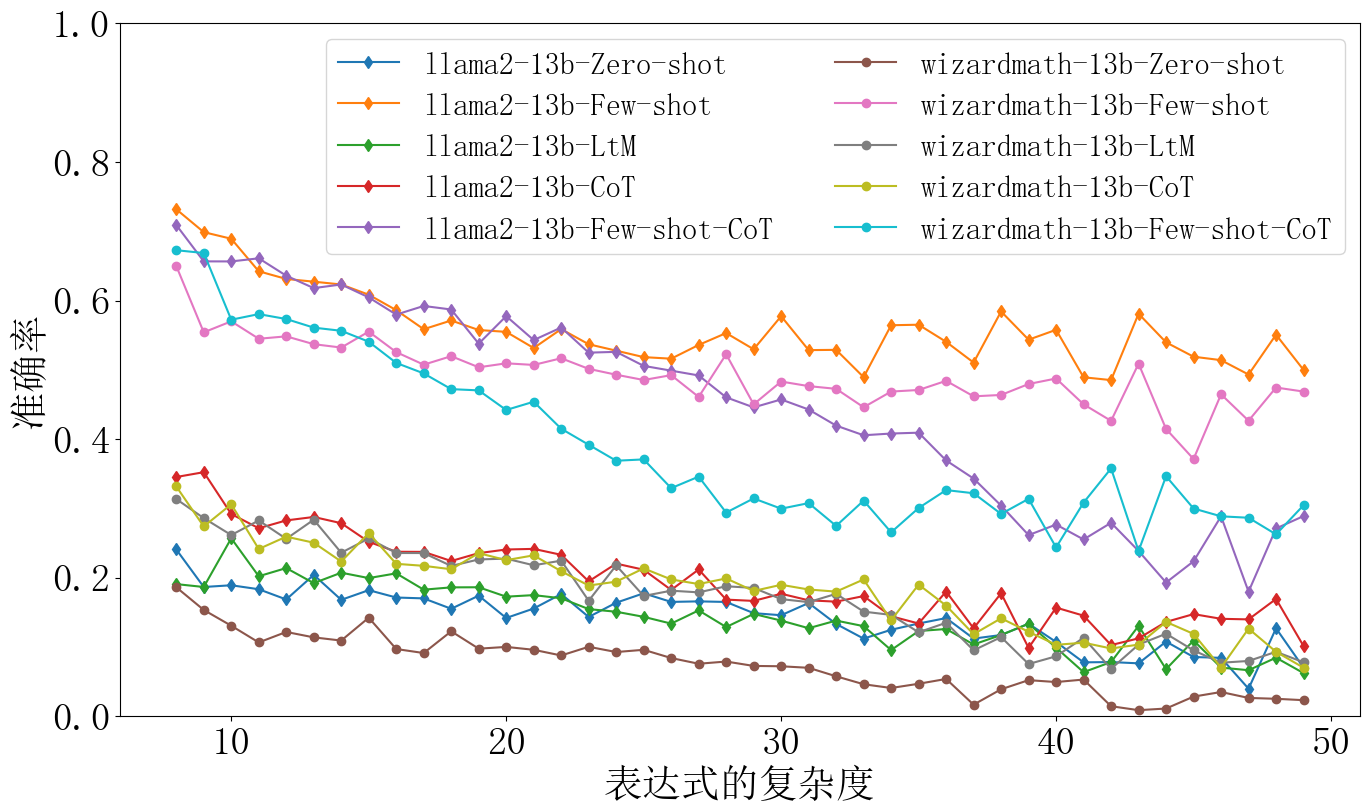

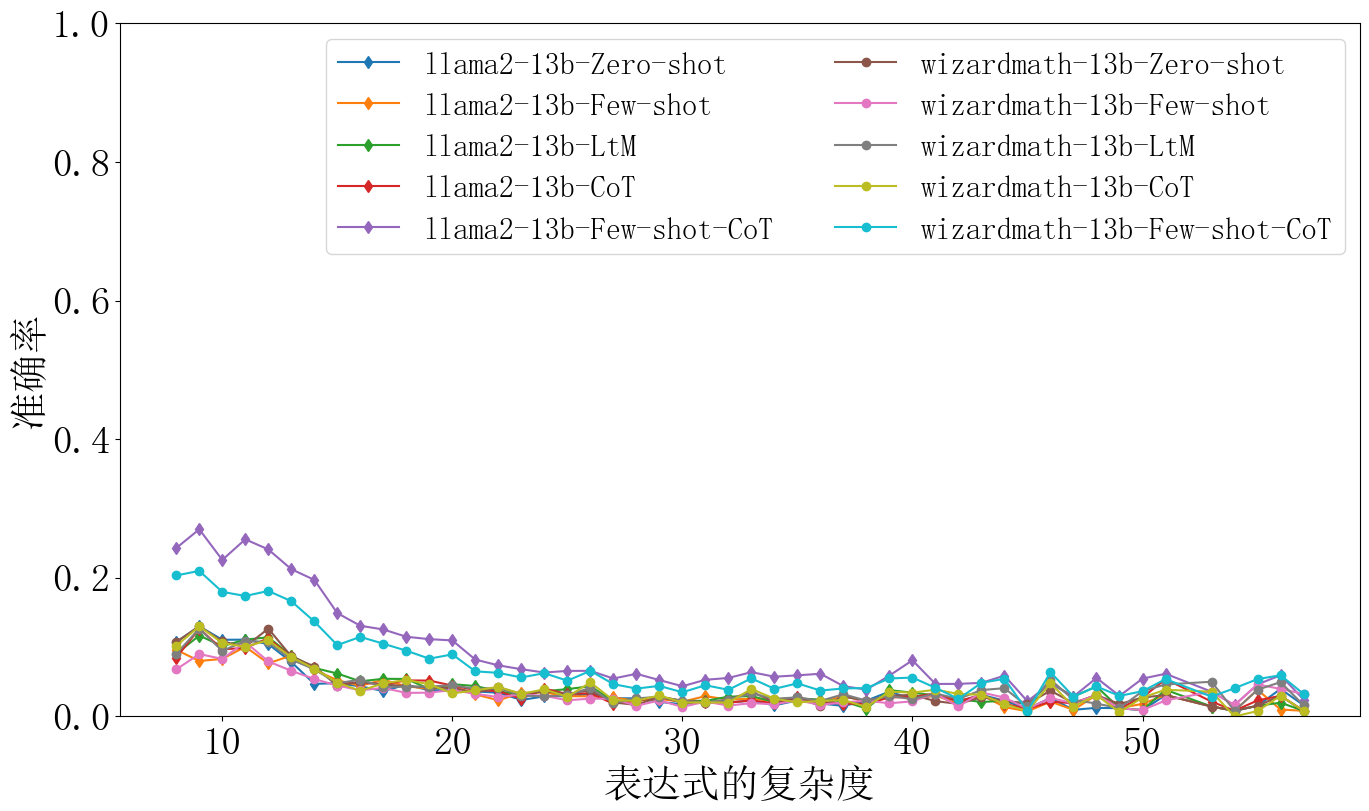

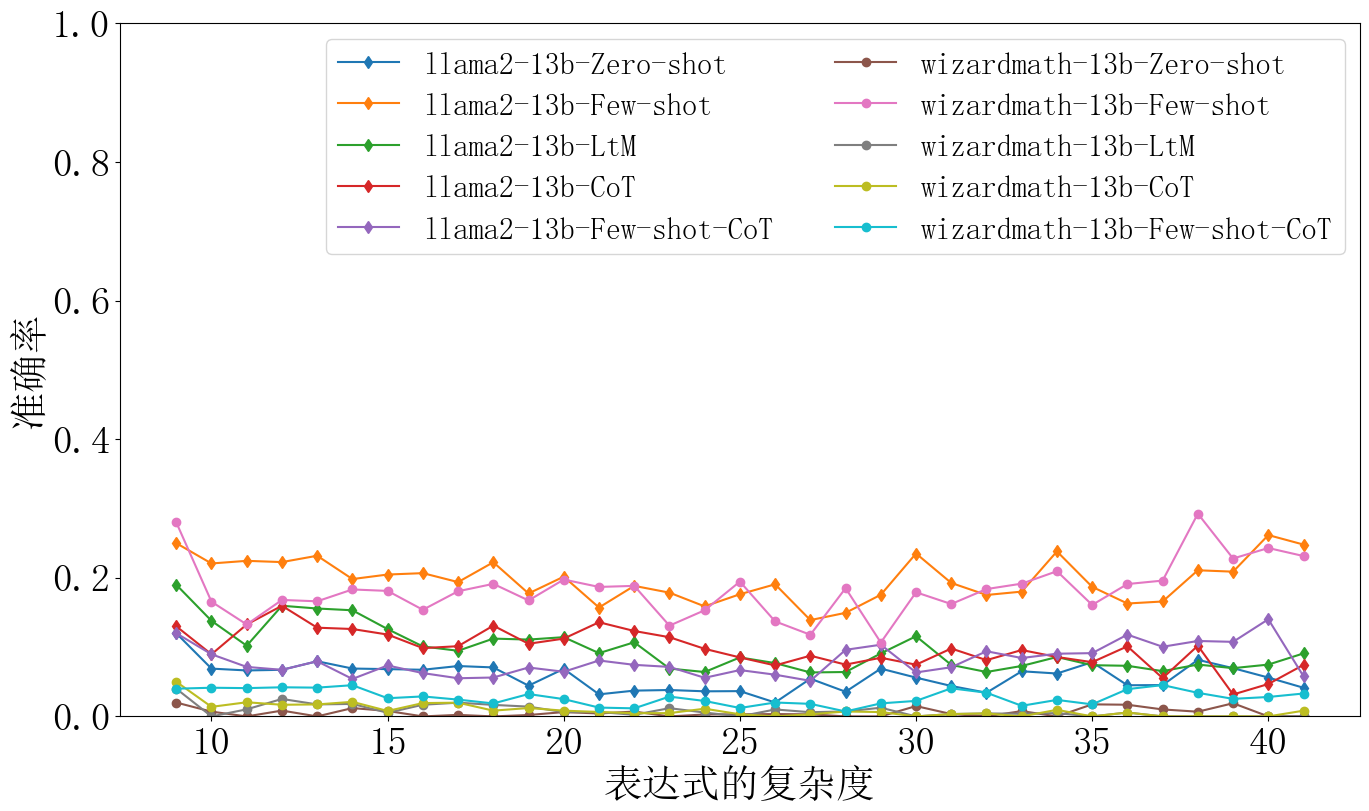

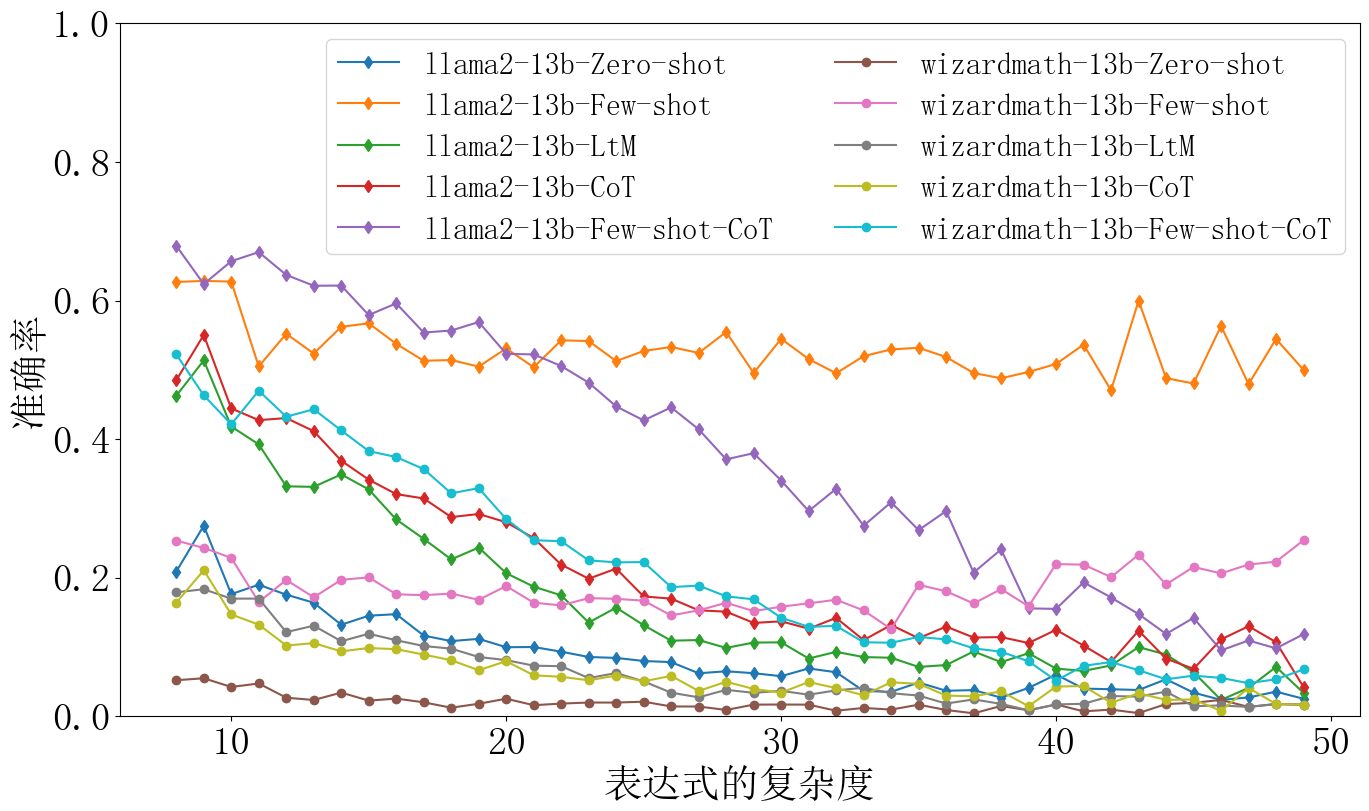

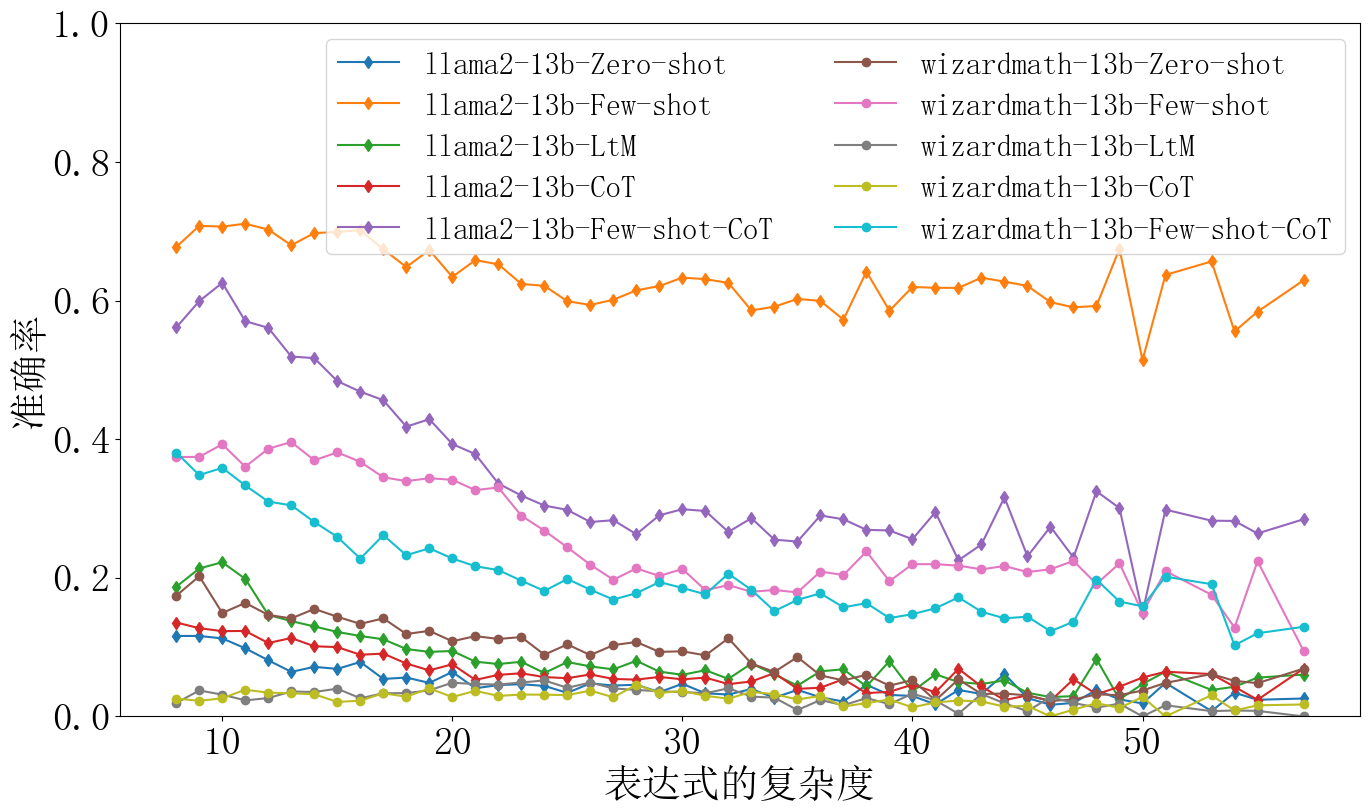

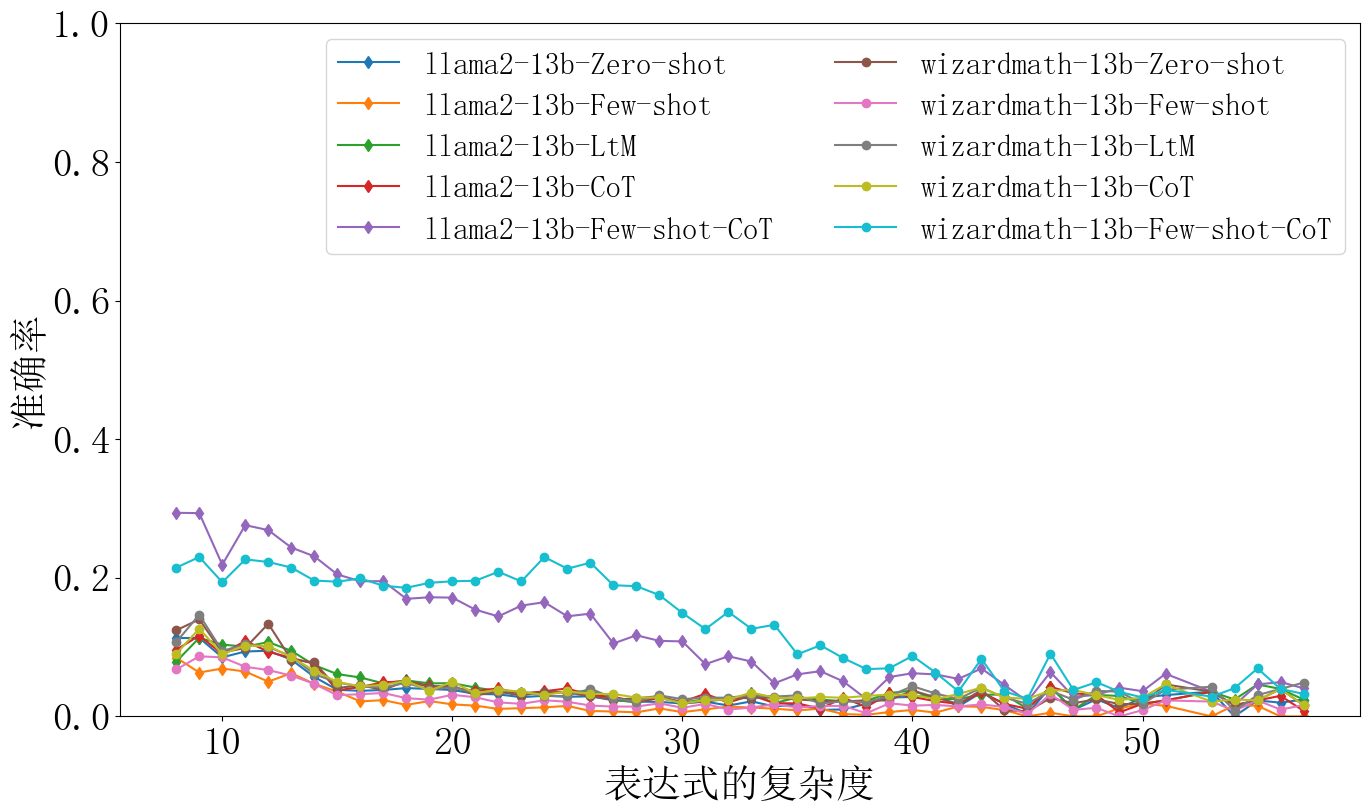

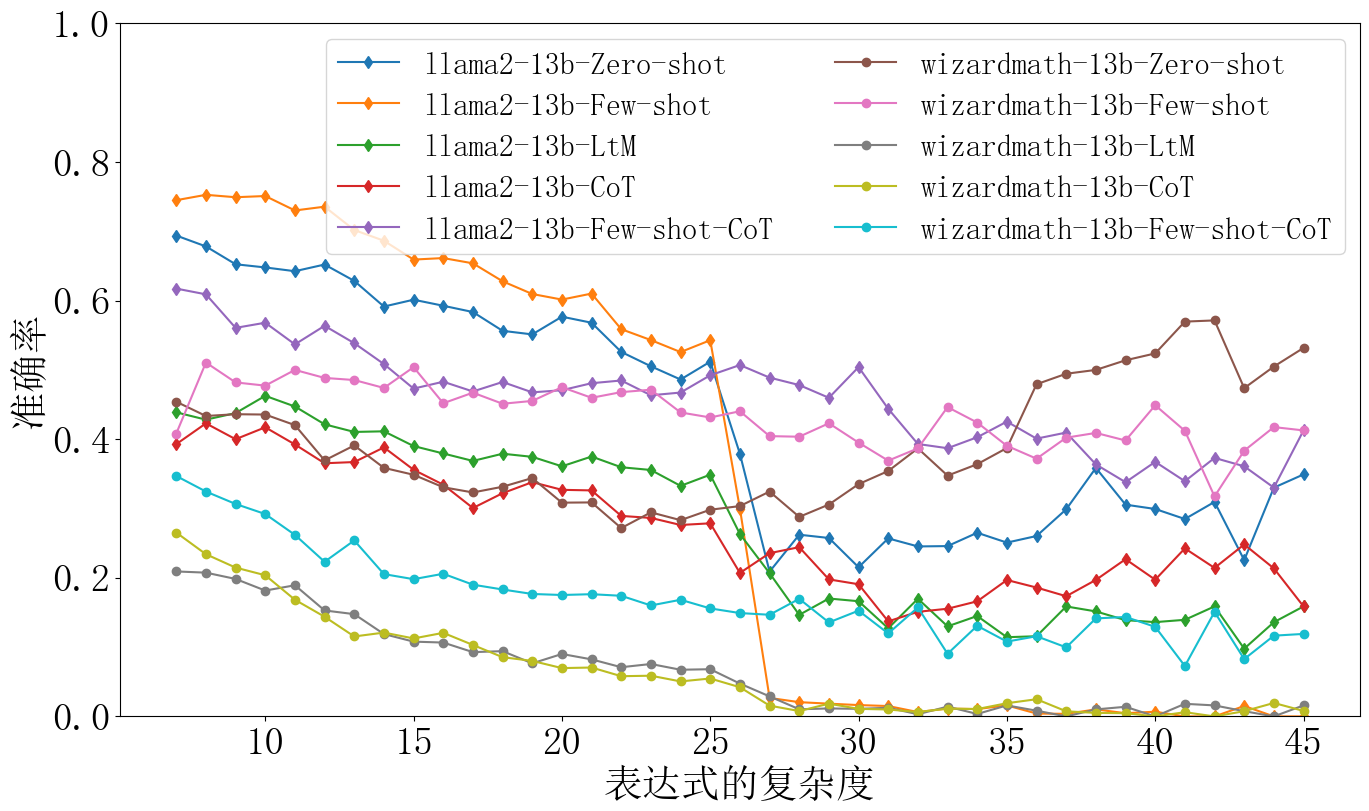

In [6]:
for problem in list(set(problem_list) - set(["EquivalentQ"])):
    visualize_discrete_distribution(problem, plot_lib='plt', 
                                    plot_range=(0,1), 
                                    savefig=f"./figs/{problem}-complexity-accuracy", 
                                    title=None)

## EquivalentQ - Stand alone due to different xlabel

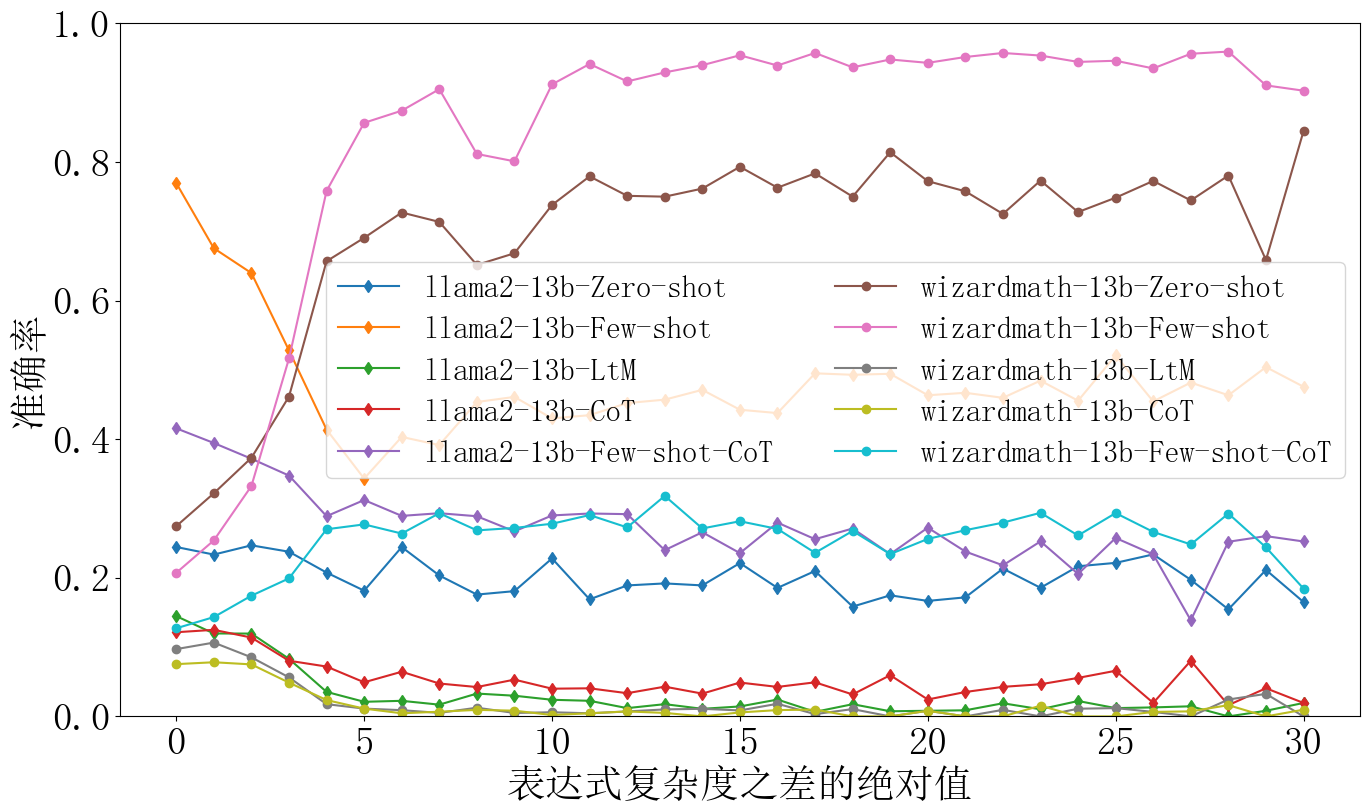

In [7]:
problem = "EquivalentQ"
visualize_discrete_distribution(problem, plot_lib='plt',
                                plot_range=(0,1), 
                                savefig=f"./figs/{problem}-complexity-accuracy", 
                                xlabel='表达式复杂度之差的绝对值',
                                title=None)